# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

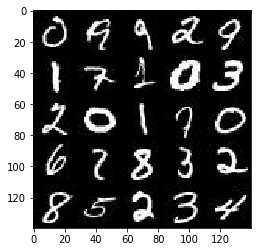

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

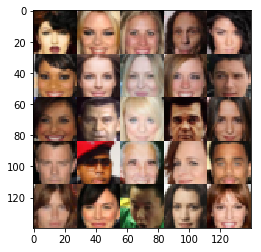

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse= reuse):
        alpha = 0.2
        stddev = 0.02
        
        # Input layer for CelebA is: 28x28x3, MNIST: 28x28x1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same",
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding="same", 
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2 * alpha, conv2)
        # 7x7x128
        
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding="same",
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(conv3 * alpha, conv3)
        # 4x4x256
        
        
        flat = tf.reshape(conv3, (-1, 4*4*256 ))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse= not is_train):
        
        alpha=0.1
        stddev=0.02
        
        fc_layer = tf.layers.dense(z, 7*7*256)
        
        
        # reshape fully connected layer
        x1 = tf.reshape(fc_layer, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        
        
        conv1 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', 
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(conv1 * alpha, conv1)
        # 14x14x128
        
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=1, padding='same', 
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(conv2 * alpha, conv2)
        # 14x14x64
            
            
        conv3 = tf.layers.conv2d_transpose(conv2, 32, 5, strides=2, padding='same', 
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(conv3 * alpha, conv3)
        # 28x28x32
        
        
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # 28x28xout_channel_dim

        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smooth))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    training_var = tf.trainable_variables()
    d_var = [var for var in training_var if var.name.startswith("discriminator")]
    g_var = [var for var in training_var if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_training_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_training_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
    return d_training_opt, g_training_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr:learning_rate})
                
                if steps % 20 == 0:
                    d_training_loss = d_loss.eval({real_input:batch_images, z_input:batch_z})
                    g_training_loss = g_loss.eval({z_input:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_training_loss),
                          "Generator Loss: {:.4f}".format(g_training_loss))
                    # Save losses to view after training
      ##              losses.append((d_training_loss, g_training_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 32, z_input, data_shape[3], data_image_mode)
                    
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.4585
Epoch 1/2... Discriminator Loss: 1.6376... Generator Loss: 2.6497
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.7284
Epoch 1/2... Discriminator Loss: 1.5761... Generator Loss: 0.4726
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.4845


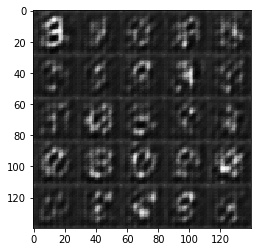

Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 1.8272
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 1.3346
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.6589
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 2.0105


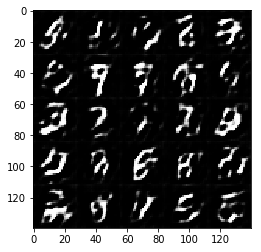

Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.8467
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 1.5536... Generator Loss: 0.4565


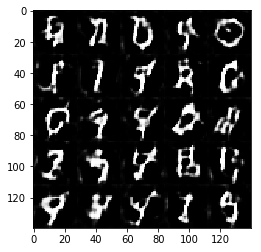

Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.7855
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 1.2426
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 1.5390... Generator Loss: 0.5051


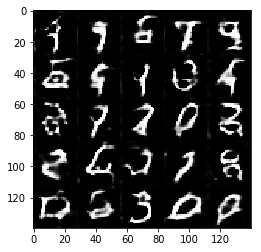

Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 1.6846
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.6454


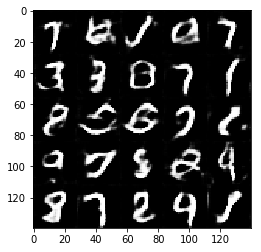

Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 2.2969
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 1.9624


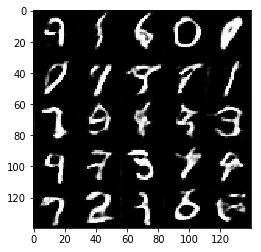

Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.9869
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.5235
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 1.3776


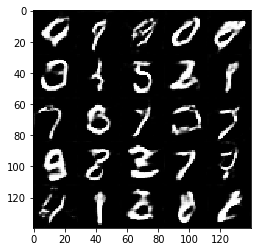

Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.4800
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 0.8842


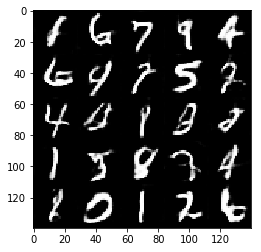

Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 1.1449
Epoch 1/2... Discriminator Loss: 2.0404... Generator Loss: 0.2540
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 1.2656


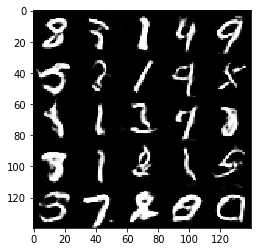

Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 1.4856
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 1.8770
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.8673


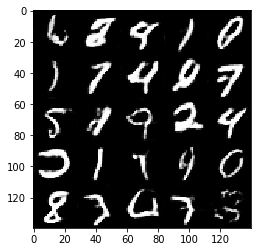

Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 1.6342... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 1.8630


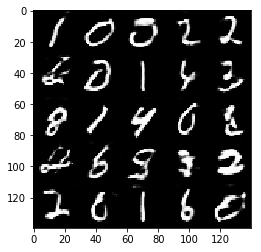

Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.3663
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.6001
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 1.0904


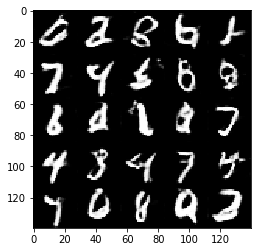

Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 1.8580
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.6179
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.5192
Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 1.2204


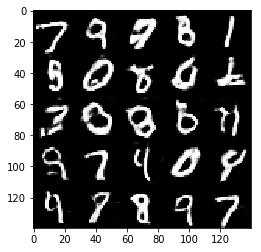

Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.8226... Generator Loss: 0.3349
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 1.3654


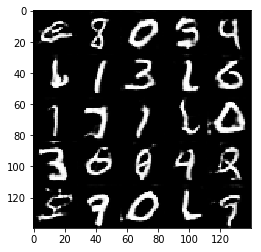

Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 1.0752
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.5411
Epoch 2/2... Discriminator Loss: 1.9849... Generator Loss: 0.2751


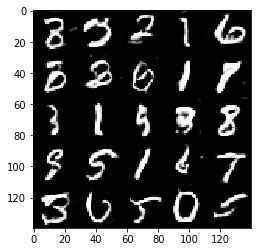

Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 1.0736
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.5448
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 1.7294
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.4788


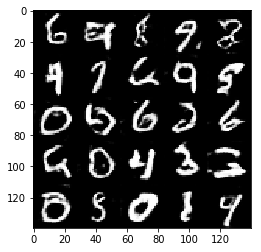

Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 1.5401
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 1.5708
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.1268


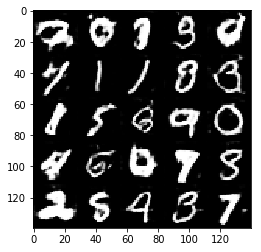

Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.6234
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.5305... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 1.2796


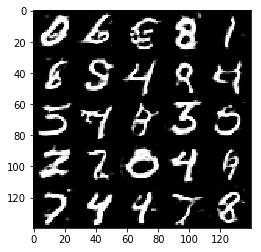

Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.8753
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 0.7473


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 1.9549
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 2.2332
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.9433
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 2.3456
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.1163


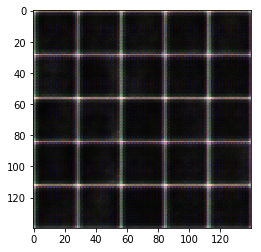

Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.7947
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.4767


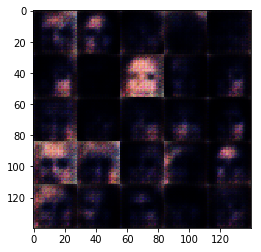

Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 1.0479


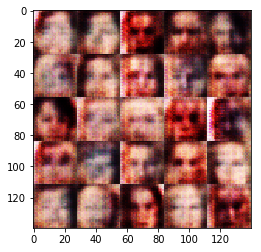

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.6075
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 2.1090


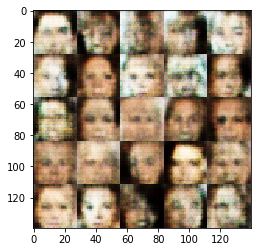

Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6512


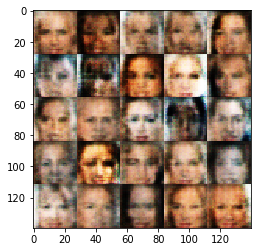

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.0018


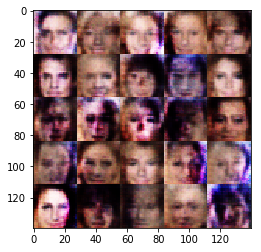

Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9760


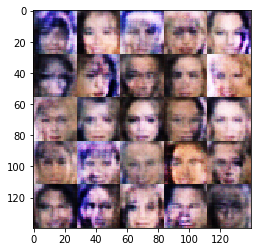

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7826


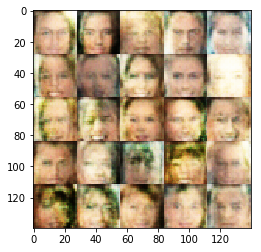

Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7108


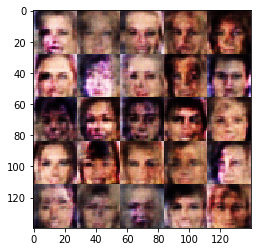

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.6252


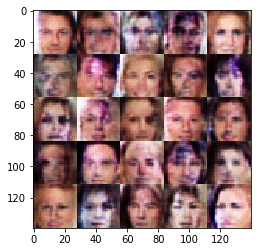

Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.0125


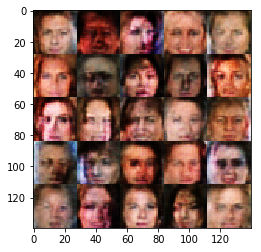

Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.0580


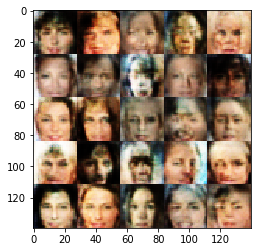

Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.2530
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5525


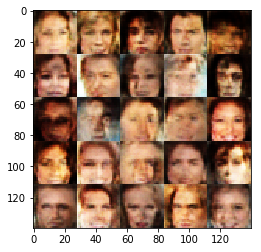

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9829


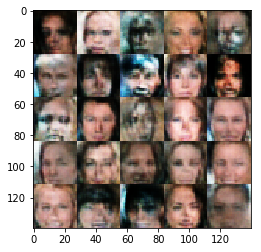

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.3914
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.3084


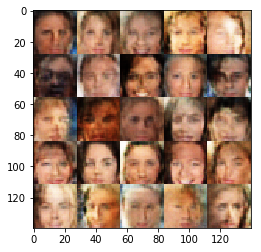

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.9028


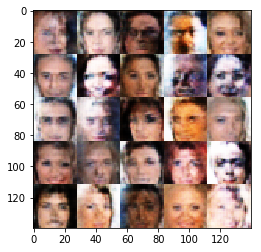

Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.6331


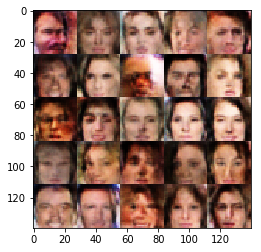

Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8392


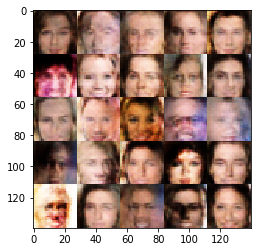

Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.1865


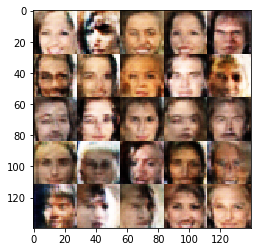

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9428


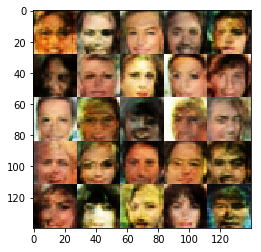

Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.0255


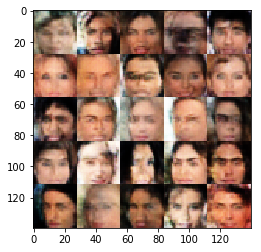

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 1.2834


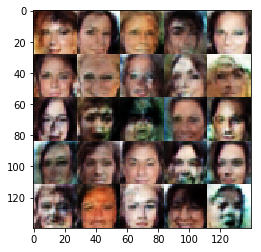

Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.0961


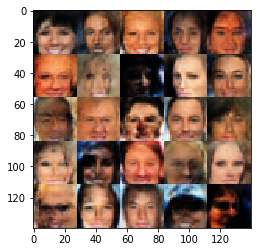

Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.4241
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.9309


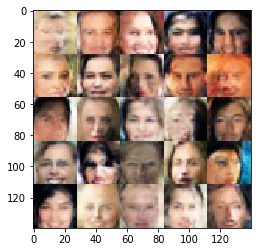

Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.9047


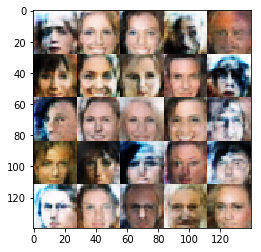

Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.9843


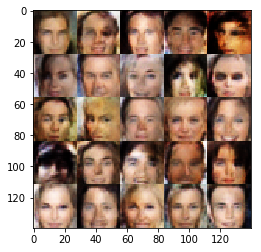

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.4978
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7163


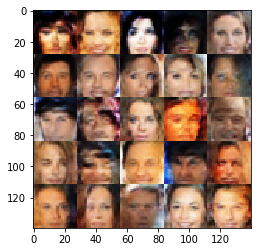

Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9020


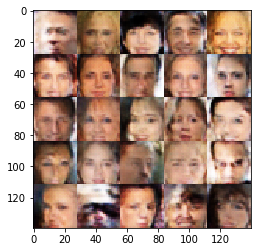

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6933


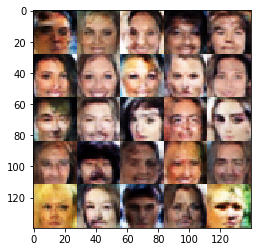

Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7261


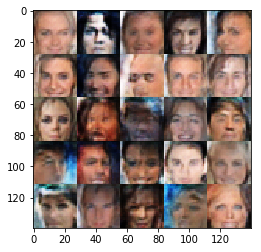

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.0745


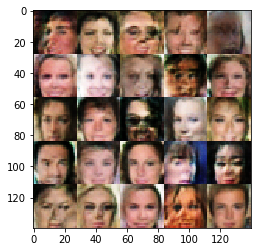

Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.9253


In [43]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.